Try to find if trajectories feature can be used to support early stopping

In [1]:
import os, sys
import json
import torch
import numpy as np


sys.path.append("..")
from singleVis.data import NormalDataProvider
from singleVis.eval.evaluator import Evaluator
from singleVis.projector import DVIProjector
from singleVis.vis_models import vis_models as vmodels

2023-10-10 16:15:36.765191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 16:15:38.027732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
VIS_METHOD = "tDVI" # DeepVisualInsight
CONTENT_PATH = "/home/xianglin/projects/DVI_data/resnet50_cifar100"
GPU_ID = "3"

In [3]:
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

In [4]:
SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]
EPOCH_NAME = config["EPOCH_NAME"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
VIS_MODEL = VISUALIZATION_PARAMETER['VIS_MODEL']
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

In [5]:
import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

In [6]:
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES, epoch_name=EPOCH_NAME, verbose=1)

Finish initialization...


In [7]:
VIS_MODEL_NAME = "tDVI_cnAE_estimation-sampling"
VIS_MODEL = "cnAE"
model = vmodels[VIS_MODEL](ENCODER_DIMS, DECODER_DIMS)
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, epoch_name=EPOCH_NAME, device=DEVICE)
evaluator = Evaluator(data_provider,projector, metric="euclidean")

In [8]:
# import json
# with open(f"{CONTENT_PATH}/noisy_label.json", "r") as f: 
#     noise_labels = np.array(json.load(f))
# with open(f"{CONTENT_PATH}/clean_label.json", "r") as f: 
#     clean_labels = np.array(json.load(f))

# idxs = np.argwhere(noise_labels!=clean_labels).squeeze()

In [9]:
# with open(f"{CONTENT_PATH}/corrupted_idxs.json", "r") as f: 
#     idxs = np.array(json.load(f))

In [10]:
idxs = np.array([])

In [11]:
# ground truth
consistency_score = np.load("/home/xianglin/projects/git_space/structural-regularity/docs/cscores/cifar100-cscores-orig-order.npz", allow_pickle=True)
consistency_score = consistency_score['scores']
# consistency_score = np.load("/home/xianglin/git_space/structural-regularity/mnist-cscores.npy", allow_pickle=True)


In [12]:
# ground truth images
import torchvision
dataset = torchvision.datasets.CIFAR100("/home/xianglin/projects/git_space/pytorch_cifar100/data", train=True)

In [15]:
END = 50

In [16]:
from singleVis.training_dynamics import TD
td = TD(data_provider, projector, (1,END,1))

/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/xianglin/miniconda3/envs/genvis/lib/python3.9/site-packages/

In [ ]:
target_idxs = np.argwhere(consistency_score<0.1).squeeze()

In [ ]:
positions = td.position_dynamics()
for i in range(10):
    td.show_ground_truth_1(positions,END, target_idxs, i, method="RoG")

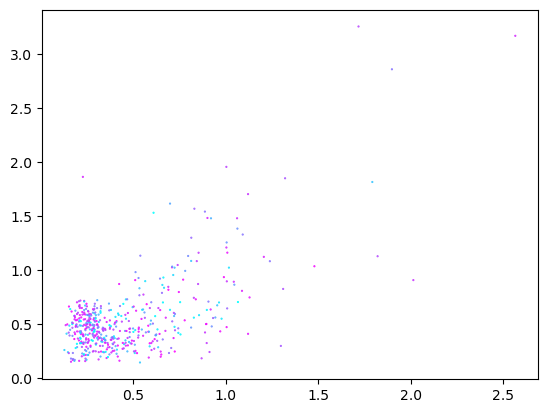

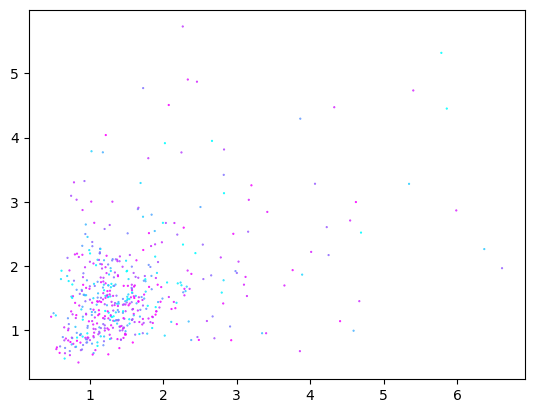

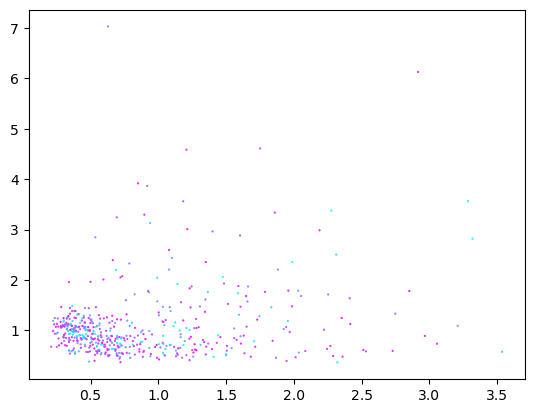

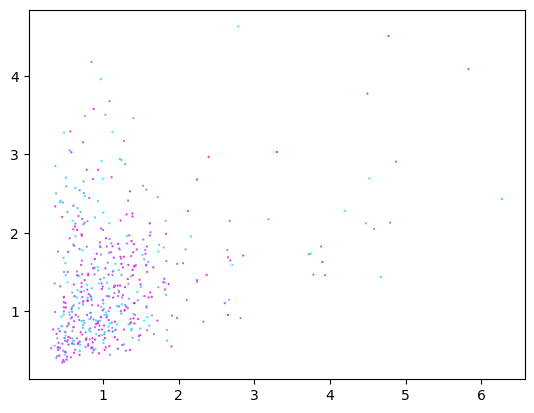

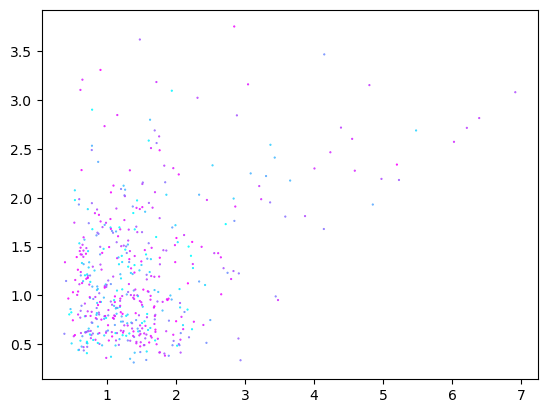

In [19]:
positions = td.position_dynamics()
for i in range(5):
    td.show_ground_truth_2(positions,END, idxs, i, method="RoG", colors=consistency_score, cmap="cool")

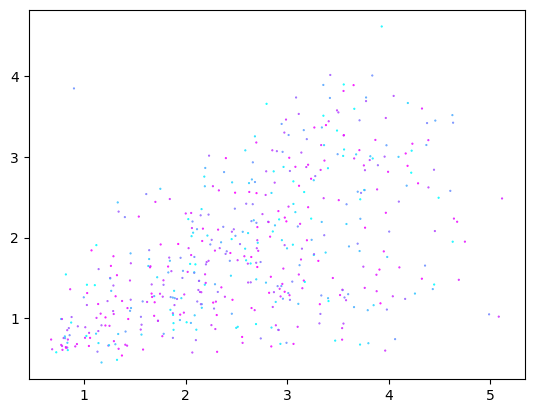

In [20]:
# show top images and bottom images
ranking = td.show_ground_truth_2(positions,END, idxs, 6, method="RoG", colors=consistency_score, cmap="cool")

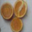

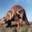

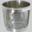

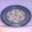

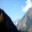

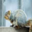

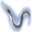

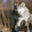

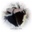

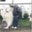

In [30]:
from IPython.display import display
for i in range(490, 500):
    display(dataset[ranking[i]][0])

In [28]:
data_provider.train_labels(1)
# dataset.targets

array([32, 33, 65, ..., 40, 96, 93])

In [ ]:
positions = td.position_high_dynamics()
trajectories = positions.reshape(len(positions), END, -1)
# Radius of Gyration
mean_t = trajectories.mean(axis=0)
embeddings = np.abs(trajectories-mean_t).mean(axis=1)

In [ ]:
EPOCH_START = td.data_provider.s
labels = td.data_provider.train_labels(EPOCH_START)

for i in range(100):
    cls_idxs = np.argwhere(labels == i).squeeze()
    mask = np.isin(cls_idxs, idxs)

    embeddings_ = td.simplify_2(embeddings[cls_idxs], END, method="UMAP")

    paint_colors = consistency_score[cls_idxs]

    mask = np.isin(cls_idxs, idxs)
    td.plot_ground_truth_2(embeddings_, mask, colors=paint_colors, cmap="cool")